## First Look at Distrubiting the Data

On the docker set up by jacopo the dask-scheduler and dask-worker commands have already been depoyed. The machines know where eachother are. To have control over them we just need to use a client to connect to the scheduler. 

In [1]:
!pip install scikit-image
!pip install dask-image

     |████████████████████████████████| 14.0 MB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 195 kB 89.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 90.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 94.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 96.8 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 59 kB/s s eta 0:00:01
     |████████████████████████████████| 86 kB 1.6 MB/s  eta 0:00:01
  Created wheel for dask-image: filename=dask_image-2021.12.0-py2.py3-none-any.whl size=41017 sha256=c05fd46f4f38e768037d9fc4eca1f95f9d877c13139070baeef823e61bfd510d
  Stored in directory: /root/.cache/pip/wheels/4b/09/2c/6c6746b9ae12023073732659be8a9c8d6e5476d8cbad37efb8
  Created wheel for pims: filename=PIMS-0.6.1-py3-none-any.whl size=82636 sha256=a9efea6d6c8f0bce942a204ecd0e7879b57b12f14dabfcaa5f8ebfd8e800be5d
  Stored in directory: /root/.cache/pip/wheels/c8/51/78/e8155864f53ff0c9e01fe656f64b55712ba60fb2a451

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
from pathlib import Path
from dask.distributed import wait


from dask_image.imread import imread
from skimage import io, transform
import dask.array as da
import matplotlib.pyplot as plt
import dask.delayed

from tensorflow.keras import models, layers

import pandas as pd

import re

import time
import timeit

In [3]:
from dask.distributed import Client
#dask-scheduler is an alias for the ip address of the scheduler. I believe it is set up in the image of the jupyter notebook machine. 
client = Client('dask-scheduler:8786')
client

<Client: 'tcp://172.31.0.2:8786' processes=6 threads=6, memory=11.62 GiB>

In [53]:
client.restart()
client.has_what()

Worker,Key count,Key list
tcp://172.30.0.3:43843,0,Expand
tcp://172.30.0.5:37337,0,Expand
tcp://172.30.0.6:35639,0,Expand
tcp://172.30.0.7:46781,0,Expand
tcp://172.30.0.8:44515,0,Expand
tcp://172.30.0.9:41557,0,Expand


In [5]:
# from dask.distributed import Client
# #dask-scheduler is an alias for the ip address of the scheduler. I believe it is set up in the image of the jupyter notebook machine. 
# client = Client('10.67.22.116:8786')
# client

# Preamble
In the preamble the labels.csv is loaded into a dask dataframe. Some basic operations are applied to get information that will be usefull later for the image pre processing. The data comefortably fits into ram and so dask automatically gives it one partition. 

First the task graph will be inspected for the entire preamble. Then the change in the task graph will be inspected as we change the number of partitions.

Then an analysis is performed for the time taken to perform the preamble as a function of the number of partitions. As the data comefortably fits into ram there is no risk of crashing the workers from too few larger partitions. It is expected that it will run the fasted with the number of partitions that equal the number of workers. This is because there is less time reading and writing. Similarly as the number of partitions grows beyond the number of workers it is expected the time taken will increase linearly. As then number of reads increases linearly.

In a later part of the notebook there is a similar analysis for varying data sizes. 

In [4]:
def loadData():
    labels_path = Path('/opt','workspace','data','labels.csv')
    df = dd.read_csv('/opt/workspace/data/labels.csv')
    df.columns = ['species', 'box_topleft_x', 'box_topleft_y', 'box_width', 'box_height', 'filename',       'image_width', 'image_height']
    meta = df.head(1)
    return df, meta
df, meta = loadData()
def preamble(df, meta, persist=False):
    df = df.drop(columns='species')
    meta = meta.drop(columns = 'species')
    #adding bottom right box corners
    # co-ordinated measured from top left corner of image being 0
    df['box_bottomright_x'] = df['box_topleft_x'] + df['box_width']
    df['box_bottomright_y'] = df['box_topleft_y'] + df['box_height']
    meta['box_bottomright_x'] = 1
    meta['box_bottomright_y'] = 1
    
    # adding the max box dimension for best size analysis
    def maxdim(partition):
        partition['max_box_dim'] = np.maximum(partition['box_width'],partition['box_height'])
        return partition
    meta['max_box_dim'] = 1
    df = df.map_partitions(maxdim, meta = meta)
    
    # adding paths for easier file reading
    def makePath(partition):
        def makePath2(row):
            return Path('/opt','workspace','data','images',row['filename'])
        partition['file_path'] = partition.apply(makePath2, axis = 1)
        return partition
    meta['file_path'] = Path()
    df = df.map_partitions(makePath, meta = meta)
    
    # add a face number (taken fromt he file name) to save the files properly
    def faceNumber(partition):
        def faceNumber2(row):
            filename = row['filename']
            found = re.search('[0-9]+',filename)
            return filename[found.start():found.end()]
        
        partition['face_number'] = partition.apply(faceNumber2, axis = 1)
        return partition
    meta['face_number'] = 'a String'
    df = df.map_partitions(faceNumber, meta = meta)

    # getting rid of images with extra faces
    df = df.groupby('filename', sort = False).first()
    meta = meta.drop(columns='filename')
    if persist==True: df = df.persist()
    return df, meta

predf, premeta = preamble(df, meta)
#predf.visualize()

In [55]:
predf5 = df
meta5 = meta
predf5 = predf5.repartition(npartitions = 5)
predf5, meta5 = preamble(predf5, meta5)
#predf5.visualize()


# Preamble Partition Test

The results of the preamble partition test is shown below. It was expected to see smaller computation times as we partition up to the number of workers as then we have paralellisation. It was expected for computation time to increase as we partition pas the number of workers as then we have more time dedicated to reading and writing. 



In [56]:
def partitionTest(fun,df,partitions,itterations):
    times = []
    for i in partitions:
        print('Number of Partitions: ',i)
        df = df.repartition(npartitions = i).persist()
        times2 = []
        for j in itterations:
            t1 = time.perf_counter()
            fun(df)
            t2 = time.perf_counter()
            times2.append(t2-t1)
        times.append(np.mean(times2))
    plt.plot(partitions,times)
    plt.xlabel('number of partitions')
    plt.ylabel('time taken in seconds')
    return times
    
def workerTest(fun,*args,**kwargs):
    #Will function, but I can't unretire the workers once they are retired
    # I think I need jakes ssh thing to reconnect to the workers
    workers = client.scheduler_info()['workers'].keys()
    times = []
    nworkers = range(len(workers))
    for worker in workers:
         client.retire_workers(workers=[worker])
         t1 = time.perf_counter()
         fun(*args, **kwargs)
         t2 = time.perf_counter()
         times.append(t2-t1)
    plt.plot(nworkers,times)
    plt.xlabel('Number of Workers')
    plt.ylabel('Times taken to Process, s')


In [8]:
partestdf = df
partitionTest(preamble,partestdf,range(1,17,1),range(3))
plt.title('Preamble Partition Test, nWorkers = 8')

Number of Partitions:  1


TypeError: preamble() missing 1 required positional argument: 'meta'

# Determining Image Size
A deep learning model must accept data of the same size. So we will rescale all of our images to this size. The mode of the max box dimension will be used as our default image size.

The mode of the max box dimensions is:  198
This will be our default image width and height for the ML model


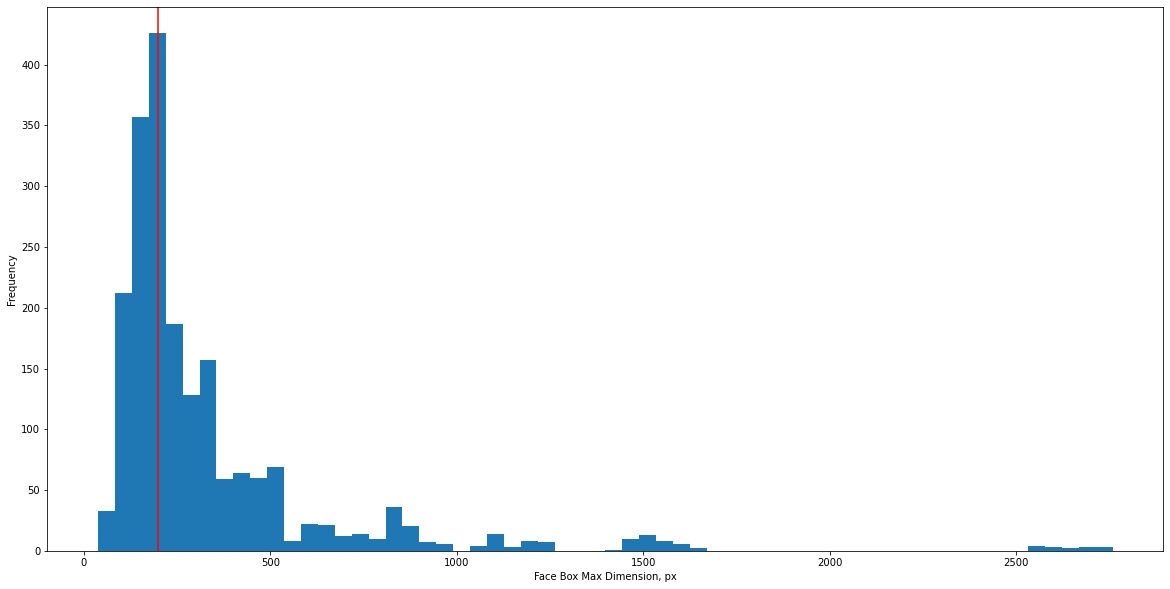

In [20]:
fig = plt.figure(figsize=(20,10))
plt.hist(df['max_box_dim'].compute(), bins = 60, log = False)
box_dim_mode = df['max_box_dim'].mode().compute()[0]
plt.axvline(box_dim_mode, color = 'red')
plt.xlabel('Face Box Max Dimension, px')
plt.ylabel('Frequency')
print('The mode of the max box dimensions is: ',box_dim_mode)
print('This will be our default image width and height for the ML model')

# Image Processing
The data in the dask data frame will be used to crop and resize the turtle images to 198x198. The turtle face will be extracted from each photo to create the Face samples. A random portions of each photo, the same size as the face portion, will be selected to create to noFace samples.

To accomplish this the face information of the data frame needs to be linked with it's corrosponding image. If I load all of the images into a dask array. It is impossable to know their order and how they match up with the dataframes information.

The first approach to overcome this is to go through each row of the dask dataframe and load the corrosponding image, manipulate it and then add it to a dask array for further processing. This works but adds an unecessary amount of reading time to the process.

The second approach is to load the images into the dataframe as a column. Then it is already there close to the face information. And can be used multiple times without the need to reload the images. This significantly increases the size of the datframe and so a small number of partitions can kill the workers.


# Getting the Face Images approach 1

The ML model will be trained to classify partial images of turtles into face and noFace. The provided images of turtles will be processed to extract the turtles faces. Labels have been provided represent a box surrounding the turtles face in each image. The boxes are not square. The ML model needs all the images to be the same size. To overcome this the shorter side is made equal to the longer size and the image is cropped to the new box. 

The next code cell will do the following:
 - run a function getFace on each dask dataframe partition, which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getFace2 on each row of the partition.
        - This function will load the image associated with the row
        - Crop the image to a square the box that is mostly taken up by the turtles face
        - Save the new image to a file. 

In [5]:
df, meta = loadData()
facedf, meta = preamble(df, meta, persist=True)
from skimage import util
def getFace(partition):
    def getFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        var = locals()
        y = image_info['box_topleft_y']
        x = image_info['box_topleft_x']
        dim = {'box_width':image_info['box_width'],'box_height':image_info['box_height']}
        max_dim_key = max(dim, key = dim.get)
        max_dim = image_info['max_box_dim']
        dif = np.abs(image_info['box_width'] - image_info['box_height'])
        half_dif = int(dif/2)
    
        if max_dim_key == 'box_width':
            new_top = y-half_dif
            new_bottom = new_top + max_dim
            pad_width = 0
            if(new_top < 0):
                pad_width = -new_top
                new_top = 0
            if(new_bottom > image_info['image_height']):
                pad_width = new_bottom - image_info['image_height']
                new_bottom = image_info['image_height']
        
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ new_top : new_bottom, x : x+max_dim, :]
            
        if max_dim_key == 'box_height':
            new_left = x-half_dif
            new_right = new_left + max_dim
            pad_width = 0
            if(new_left < 0):
                pad_width = -new_left
                new_left = 0
            if(new_left > image_info['image_width']):
                pad_width = new_left - image_info['image_width']
                new_left = image_info['image_width']
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ y : y+max_dim, new_left : new_right, :]
        path = Path('/opt','workspace','data','Faces3','face_'+image_info['face_number']+'.jpg')
        face = transform.resize(face,(198,198,3))
        face = util.img_as_ubyte(face)
        #io.imsave(path,face)
        return [face]
    partition['face_img'] = partition.apply(getFace2, axis = 1)
    return partition
    
facedf = facedf.repartition(npartitions=1000).persist()
#facedf = facedf.partitions[0:3]
def face(facedf, meta):
    facedf = facedf.map_partitions(getFace, meta = meta).persist()
    wait(facedf)
    return facedf
meta['face_img'] = [np.zeros((198,198,3))] 
facedf = face(facedf, meta)
# partitionTest2(face,facedf,start=1,stop=16,step=1)
# plt.title('Getting Face Images Partition Test')


In [10]:
facedf.head()

,box_topleft_x,box_topleft_y,box_width,box_height,image_width,image_height,box_bottomright_x,box_bottomright_y,max_box_dim,file_path,face_number,face_img
filename,,,,,,,,,,,,
Image_10.jpg,3232,777,874,848,5616,2633,4106,1625,874,/opt/workspace/data/images/Image_10.jpg,10,"[[[[ 0 196 244], [ 0 196 244], [ 0 197 245]..."


# Getting the noFace images approach 1

The ML model will be trained to classify partial images of turtles into face and no face. The provided images of turtles will be processed to extract sections of those images that do not contain a face. To do this the information in the dataframe of the face location is required.

The next code cell will do the following:
 - run a function getNoFace on each dask dataframe partition which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getNoFace2 on each row of the partition.
        - This will load the image associated with the row
        - split it into four images, one on each side of the turtle face box, these images are called sides
        - Take the largest of these four sides and take a random chunck about the same size as the face box. This is the extracted noFace image. (This makes sure the no face images are as similar as possible to the face image, in terms of resolution and amount of the turtle visable)
        - Sometimes the largest side is smaller then the face box. In this case the largest random square is taken as the noFace Image.
        - The noFace image extraced is resized to 198 by 198 pixels. (This is the mode of the largest facebox dimension, and so most of the face images are limited to this ammount of imformation.)
        - The the new noFace image is then saved to a file.
 

In [6]:
def getNoFace(partition):
    def getNoFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        im_left = im[:, 0:image_info['box_topleft_x'] ,:]
        im_right = im[:, image_info['box_bottomright_x']: ,:]
        im_top = im[0:image_info['box_topleft_y'],:,:]
        im_bottom = im[image_info['box_bottomright_y']:,:,:]
        var = locals()
        sizes ={'im_left':np.min(np.shape(im_left)[0:2]),'im_right':np.min(np.shape(im_right)[0:2]),'im_top':np.min(np.shape(im_top)[0:2]),'im_bottom':np.min(np.shape(im_bottom)[0:2])}
        max_side_key = max(sizes, key = sizes.get)
        rand_gen = np.random.default_rng(12345)
        max_box_dim = np.max([image_info['box_width'],image_info['box_height']])
        if sizes[max_side_key]<max_box_dim:
            side = var[max_side_key]
            dim = np.shape(side)[0:2]
            side_max_ind = np.argmax(dim)
            side_min_ind = not side_max_ind
            high = dim[side_max_ind] - dim[side_min_ind]
            along = rand_gen.integers(low = 0, high = high)
            if(side_max_ind == 0):
                noFace = side[along:along+dim[side_min_ind],:,:]
            elif(side_max_ind == 1):
                noFace = side[:, along:along+dim[side_min_ind] ,:]
        else:
            side = var[max_side_key]
            side_width = np.shape(side)[1]
            side_height = np.shape(side)[0]
            rtlx = rand_gen.integers(low = 0, high = side_width - max_box_dim)
            rtly = rand_gen.integers(low = 0, high = side_height - max_box_dim)
            noFace = side[rtly:rtly+max_box_dim, rtlx:rtlx+max_box_dim, :]
        noFace = transform.resize(noFace,(198,198,3)) 
        path = Path('/opt','workspace','data','noFaces3','noFace_'+image_info['face_number']+'.jpg')
        #io.imsave(path,noFace)
        return [noFace]
    partition['noFace_img'] = partition.apply(getNoFace2, axis = 1)
    return partition
    

#facedf = facedf.partitions[0:3]
def noFace(nofacedf, meta):
    nofacedf = facedf.map_partitions(getNoFace, meta = meta).persist()
    wait(nofacedf)
    return nofacedf
meta['noFace_img'] = [np.zeros((198,198,3))] 
nofacedf = noFace(facedf, meta)
        
#partitionTest2(noface,nofacedf)

In [11]:
len(nofacedf)

1999

# Distributed Tensorflow CNN

In [7]:
# extract the usefull information from the datafram
drop = ['box_topleft_x','box_topleft_y','box_width','box_height','image_width','image_height','box_bottomright_x','box_bottomright_y','max_box_dim','file_path']
data = nofacedf.drop(columns=drop)
data = data.set_index('face_number')
data.head()


,face_img,noFace_img
face_number,,
10,"[[[[ 0 196 244], [ 0 196 244], [ 0 197 245]...",[[[[7.20033359e-04 6.90920074e-01 9.14448077e-...


In [8]:
# marcos cnn model
def build_cnn():
    cnn = models.Sequential([
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #summary
    #print(cnn.summary())
    return cnn

#function to turn a pandas partition of the data into a form the model will accept
def extractData(pdf):
    faces = pdf['face_img'].tolist()
    faces = [i[0] for i in faces]
    faces = np.array(faces)
    labelsF = np.ones(len(faces))    
    nofaces = pdf['noFace_img'].tolist()
    nofaces = [i[0] for i in nofaces]
    nofaces = np.array(nofaces)
    labelsNF = np.zeros(len(nofaces))
    data = np.concatenate((faces,nofaces), axis = 0)
    labels = np.concatenate((labelsF,labelsNF))
    return data, labels

#a delayed function to be applyed to each partition of the dd that hold the validation data
#The returned futures can then be converted into a form marco's model will accept  
@dask.delayed
def extractValData(pdf):
    data, labels = extractData(pdf)
    val = pd.DataFrame()
    val['v_data'] = [data]
    val['v_labels'] = [labels]
    return (data,labels)

# seperating into training and validation sets. Then brining the validation to the working machine
#too high and it will crash the workers, too low and our validations are innaccurate
n_rows = 400#marco did 400
v_ind = [str(i) for i in range(2,n_rows+2)]
t_ind = [str(i) for i in range(n_rows+2,len(data))]
v_data = data.loc[v_ind]
t_data = data.loc[t_ind]

v_data = v_data.repartition(npartitions=100)
v_meta = pd.DataFrame()
v_meta['v_data'] = [np.ones((2,2))]
v_meta['v_labels'] = [np.ones((2,2))]

v_data_futures = []
for partition in v_data.partitions:
    future = extractValData(partition)
    v_data_futures.append(future)

v_data = [future.compute() for future in v_data_futures]
v_labels = np.concatenate([i[1] for i in v_data])
v_data = np.concatenate([i[0] for i in v_data],axis = 0)



In [9]:
n_rowsper_part = 5
n_rows = len(t_data)
n_part = n_rows//n_rowsper_part
t_data = t_data.repartition(npartitions=n_part)

In [10]:
t_data = t_data.persist()
wait(t_data)
a = 5

In [11]:
# def train(partition):
#     #data, labels = extractData(partition)
# #     cnn = cnn.set_weights(weights)
# #     fit = cnn.fit(data,labels, epochs = epochs)
# #     weights = cnn.get_weights()
# #     loss, acc = fit.validate(v_data, v_labels)
# #     results = pd.DataFrame()
# #     results['acc'] = acc
# #     results['weights'] = weights
#     res = pd.DataFrame()
#     res['type'] = type(partition)
#     #res['labels'] = [labels]
#     return res
# t_d = t_data.partitions[0:3]
# # cnn = build_cnn()
# # weights = cnn.get_weights()
# #epochs = 10
# tr_meta = pd.DataFrame()
# tr_meta['type'] = type(pd.DataFrame)
# #tr_meta['lables'] = [np.ones(4)]
# res = t_d.map_partitions(train, meta = tr_meta)
# # cnn = build_cnn()
# # init_weights = cnn.get_weights()
# # test = data.partitions[0]
# # meta = pd.DataFrame(data=[0.1,init_weights],columns=['accuracy','weights'])

# # test.map_partitions(train,(cnn),meta = meta).compute()

In [ ]:
for i in range(len(v_data)):
    print(i)
    vd_small = v_data[:i]
    vl_small = v_labels[:i]
    vd_small = client.scatter(vd_small)
    vl_small = client.scatter(vl_small)

In [12]:
vd_small = v_data[:50]
vl_small = v_labels[:50]
vd_small = client.scatter(vd_small)
vl_small = client.scatter(vl_small)

In [24]:
print(vl_small.result())

1.0


In [101]:
ls = v_labels[0:2]
ds = v_data[0:2]

In [70]:
import dask.bag as db
@dask.delayed
def train(partition, weights, v_data, v_labels):#, cnn, v_data, v_labels, weights, epochs):
    cnn = build_cnn()
    cnn.set_weights(weights)
    data, labels = extractData(partition)
    fit = cnn.fit(data,labels, epochs = 1)
    weights = cnn.get_weights()
    loss, acc = cnn.evaluate(v_data, v_labels)
    return (acc,weights)


# def evalu(weights, v_data, v_labels):
#     cnn = build_cnn()
#     #cnn.set_weights(weights)
#     #loss, acc = cnn.evaluate(v_data,v_labels)
#     return weights
    
t_d = t_data.partitions[0:3]
t_d = t_d.persist()
wait(t_d)
cnn = build_cnn()
weights = cnn.get_weights()
# #epochs = 10
results = []
for partition in t_d.partitions:
    results.append(train(partition, weights, vd_small, vl_small))#, cnn, v_data, v_labels, weights, epochs))
    
acc = [res.compute()[0] for res in results]
i_best = np.argmax(acc)
print(np.argmax(acc))
best_weights=results[i_best].compute()[1]

# results = []
# for partition in t_d.partitions:
#     results.append(train(partition, best_weights, vd_small, vl_small))
# # r_weights = db.from_delayed(r_weights)



# cnn = build_cnn()
# init_weights = cnn.get_weights()
# test = data.partitions[0]
# meta = pd.DataFrame(data=[0.1,init_weights],columns=['accuracy','weights'])

# test.map_partitions(train,(cnn),meta = meta).compute()

KeyboardInterrupt: 

In [68]:
print(acc)

[0.5199999809265137, 0.5199999809265137, 0.5199999809265137]


In [66]:
len(r_weights[2].compute()[1])

8

In [50]:
r_weights = r_weights.persist()
wait(r_weights)
a=1



In [52]:
r_weights.compute()

TypeError: object of type 'float' has no len()

In [47]:
print(len(r_weights.compute()[0]))

3


In [42]:
ans = db.map(evalu,r_weights,vd_small,vl_small)

In [46]:
print(len(ans.compute()[0]))

3


In [95]:
ans[0][1]

1.0

In [31]:
np.shape(v_labels)

(800,)

In [ ]:
db.map(lambda(print()))

In [70]:
db.map(lambda x: print(x), r_weights).compute()

TypeError: 'Bag' object is not subscriptable

In [67]:
shp = r_weights.map(evalu,(ds,ls))

In [68]:
shp.compute()

TypeError: evalu() missing 1 required positional argument: 'v_labels'

In [17]:
res.result().result()

Delayed('result-ca148f49-a64a-41ba-9b85-0d867987c255')

In [169]:
len(ans)

TypeError: object of type 'type' has no len()

In [144]:
print(np.shape(v_data))

(800, 198, 198, 3)


In [131]:
np.shape(v_data_futures[3].compute()[0])

(10, 198, 198, 3)

In [52]:
test = v_data.partitions[0]
test = test.compute()
tdata, tlables = extractData(test)

In [56]:
tlables

array([1., 1., 1., 1., 0., 0., 0., 0.])

In [85]:
a = v_data.head()
print(type(a['v_data'][0]))

<class 'numpy.ndarray'>


In [75]:
print(len(v_data))

100


# Image Processing Performance

In the next cells the following tests will be deployed:

- Partition Test, monitoring the processing time at different numbers of partitions

- Memory Graphs, Showing the memory usage of a worker at 

# adding images to the dataframe for approach 2

In [19]:
df = loadData()
predf = preamble(df)
# only about 2 images per partition to prevent workors dying from memory overload
predf = predf.repartition(npartitions=1000)
def images(partition):
    def images2(row):
        im = io.imread(row['file_path'])
        return im
    partition['image'] = partition.apply(images2, axis = 1)
    return partition
columns = list(predf.columns.values)
columns.append('image')
meta = pd.DataFrame(data = [[1,2,3,4,5,6,7,8,9,Path('/~'),'facenumber',np.zeros(1)]],columns=columns)
imgdf = predf.map_partitions(images, meta = meta)
imgdf

,box_topleft_x,box_topleft_y,box_width,box_height,image_width,image_height,box_bottomright_x,box_bottomright_y,max_box_dim,file_path,face_number,image
npartitions=1000,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


# Getting the face images approach 2

The only difference with the first approach is that now the images are in the dataframe with the face data. And so already loaded.

In [17]:
def partitionTest3(fun,df, partitions,itterations=1):
    times = []
    for i in partitions:
        print('Number of Partitions: ',i)
        df = df.repartition(npartitions = i)
        print('1')
        df = df.persist()
        print('2')
        times2 = []
        for j in range(itterations):
            t1 = time.perf_counter()
            workers = client.scheduler_info()['workers'].keys()
            print(workers)
            print('2.5')
            fun(df)
            print('3')
            t2 = time.perf_counter()
            times2.append(t2-t1)
        times.append(np.mean(times2))
    plt.plot(partitions,times)
    plt.xlabel('number of partitions')
    plt.ylabel('time taken in seconds')
    return seq, times

In [ ]:
from skimage import util
def getFace(partition):
    def getFace2(image_info):
        im = image_info['image'] #******************************* only line thats different
        im = im[:,:,:3]# remove fourth channel if it exists
        var = locals()
        y = image_info['box_topleft_y']
        x = image_info['box_topleft_x']
        dim = {'box_width':image_info['box_width'],'box_height':image_info['box_height']}
        max_dim_key = max(dim, key = dim.get)
        max_dim = image_info['max_box_dim']
        dif = np.abs(image_info['box_width'] - image_info['box_height'])
        half_dif = int(dif/2)
    
        if max_dim_key == 'box_width':
            new_top = y-half_dif
            new_bottom = new_top + max_dim
            pad_width = 0
            if(new_top < 0):
                pad_width = -new_top
                new_top = 0
            if(new_bottom > image_info['image_height']):
                pad_width = new_bottom - image_info['image_height']
                new_bottom = image_info['image_height']
        
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ new_top : new_bottom, x : x+max_dim, :]
            
        if max_dim_key == 'box_height':
            new_left = x-half_dif
            new_right = new_left + max_dim
            pad_width = 0
            if(new_left < 0):
                pad_width = -new_left
                new_left = 0
            if(new_left > image_info['image_width']):
                pad_width = new_left - image_info['image_width']
                new_left = image_info['image_width']
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ y : y+max_dim, new_left : new_right, :]
        path = Path('/opt','workspace','data','Faces3','face_'+image_info['face_number']+'.jpg')
        face = transform.resize(face,(198,198,3))
        face = util.img_as_ubyte(face)
        io.imsave(path,face)
    partition.apply(getFace2, axis = 1)

def face(facedf):
    meta = pd.DataFrame()
    facedf.map_partitions(getFace, meta = meta).compute()

partitions = [1000,500,250,125,50,6]
partitionTest3(face,imgdf,partitions)
plt.title('Getting Face Images Partition Test, approach 2')

# Scalling up

One great advantage of using a distributed system is the ability to process data of size beyond the ram limit of the resources. To test our code for multiple data sizes the data will be duplicated.

Ram Limit of system:
6 workers of 2GB each (1.9 for now)



In [33]:
#load all images into dataframe with large number of partitions
# save it to a parquet file
# predict the ram usage of the file
# use this to guess ideal partitions
# load it with lower numbers of partitions unitll it wont load without killing workers, this is min partitions
# do partition analysis from min and above

# The ram usage of the file tells us how many duplications will take us to the ram limit. 
# plot number of duplications as a function of ram size, make many parque files with different numbers of duplications

In [34]:
from dask.distributed import wait, progress
from time import sleep
#client.rebalance([predf.persist(), workers])
def minPartTest(df,start=1000,stop=1,step=100):
    print('Testing min partitions')
    for npart in reversed(range(stop,start,step)):
        print('testing: ',npart)
        df = df.repartition(npartitions=npart)
        df = df.persist() 
        wait
        workers = client.scheduler_info()['workers'].keys()
        if len(workers)==0:
            print('Broken at npartitions:',npart)
            break
    return df
        

In [35]:
predf = minPartTest(predf)

Testing min partitions
testing:  901
testing:  801
testing:  701
testing:  601
testing:  501
testing:  401
testing:  301
testing:  201
testing:  101
testing:  1


# dump

In [10]:
workers = client.scheduler_info()['workers'].keys()
print(len(workers))
#client.processing(workers)

6


In [12]:
# min number of partitions finder.
# does reshuffling help

from dask.distributed import wait, progress
wait

<function distributed.client.wait(fs, timeout=None, return_when='ALL_COMPLETED')>

In [ ]:
from skimage import io, transform
import numpy as np
from pathlib import Path

for i in range(1,2104):
        if (i%100==0): print(i)
        try: im = io.imread(Path('data/noFaces2/Image_'+str(i)+'.jpg'))    
        except:
            try: im = io.imread(Path('data/images/Image_'+str(i)+'.jpeg'))
            except:
                try: im = io.imread(Path('data/images/Image_'+str(i)+'.png'))
                except:
                    try: io.imread(Path('data/images/Image_'+str(i)+'.JPG'))
                    except:
                        print('File Not Found')
                        continue
        scale_factor = np.shape(im)[0]/500
        im = transform.rescale(im, scale= scale_factor,multichannel=True)
        io.imsave(Path('data/faces198/face_'+str(i)),arr = im)

In [ ]:
# rescale im
from skimage import io, transform
for i in range(1,2104):
    scale_factor = box_mode/500
    im = io.imread('data/faces/face_'+str(i))
    im = transform.rescale(im, scale= scale_factor)
    io.imsave('data/faces198/face_'+str(i),im)

In [72]:
import re
txt = 'fgdfghhh510045dfgdf'
a = re.search('[0-9]+',txt)
print(a.start(),a.end())
print(txt[8:14])

8 14
510045


In [ ]:
#adding the images as numpy arrays
predf = predf.repartition(npartitions=500)
def images(partition):
    def images2(row):
        im = io.imread(row['file_path'])
        return im
    partition['image'] = partition.apply(images2, axis = 1)
    return partition
meta = pd.DataFrame(data = )
meta['image'] = [np.zeros((2,2))]
predf = predf.map_partitions(images, meta = meta)

In [ ]:
# Preamble Performance Report
from dask.distributed import performance_report

with performance_report(filename="preamble-report2.html"):
    df = loadData()
    df = preamble(df, persist=True)
    
from IPython.display import HTML
HTML(filename="preamble-report.html")

In [ ]:
from dask.distributed import performance_report

with performance_report(filename="image_col.html"):
    predf.persist()
from IPython.display import HTML
HTML(filename="preamble-report.html")


In [101]:
def split(x, n):
    ans = []
    # If we cannot split the
    # number into exactly 'N' parts
    if(x < n):
        print(-1)
 
    # If x % n == 0 then the minimum
    # difference is 0 and all
    # numbers are x / n
    elif (x % n == 0):
        for i in range(n):
            ans.append(x//n)
    else:
        # upto n-(x % n) the values
        # will be x / n
        # after that the values
        # will be x / n + 1
        zp = n - (x % n)
        pp = x//n
        for i in range(n):
            if(i>= zp):
                ans.append(pp + 1)
            else:
                ans.append(pp)
    return ans

n_workers = len(client.scheduler_info()['workers'].keys())
npar = nofacedf.npartitions
indexes = np.cumsum([0]+split(npar,n_workers))
print(indexes)
#split the dataframe into a list dask dataframes. One dataframe for each worker
batches = []
for i in range(n_workers): 
    batch = nofacedf.partitions[indexes[i]:indexes[i+1]]
    batches.append(batch)

def train(pdf,weights,nepochs,cnn):
    faces = pdf['faces_img'].tolist()
    faces = [i[0] for i in faces]
    faces = np.array(faces)
    labelsF = np.ones(len(faces))    
    nofaces = pdf['noFaces_img'].tolist()
    nofaces = [i[0] for i in nofaces]
    nofaces = np.array(nofaces)
    labelsNF = np.zeros(len(nofaces))
    data = np.concatenate(faces,nofaces, axis = 0)
    lables = np.concatenate(labelsF,labelsNF)
    cnn.fit(data,lables,shuffle=True)
    
partitions = nofacedf.to_delayed()

    
# for batch in batches:
#     batch.map_partitions(train,(weights,nepochs,cnn))
    

[299, 300, 300, 300, 300, 300]

In [122]:
import dask
n_workers = len(client.scheduler_info()['workers'].keys())
npar = nofacedf.npartitions
indexes = np.cumsum([0]+split(npar,n_workers))
print(indexes)
#split the dataframe into a list dask dataframes. One dataframe for each worker
batches = []


for i in range(n_workers): 
    batch = dask.delayed(partitions[indexes[i]:indexes[i+1]])
    batches.append(batch)

def extractData(pdf):
    faces = pdf['faces_img'].tolist()
    faces = [i[0] for i in faces]
    faces = np.array(faces)
    labelsF = np.ones(len(faces))    
    nofaces = pdf['noFaces_img'].tolist()
    nofaces = [i[0] for i in nofaces]
    nofaces = np.array(nofaces)
    labelsNF = np.zeros(len(nofaces))
    data = np.concatenate(faces,nofaces, axis = 0)
    lables = np.concatenate(labelsF,labelsNF)
    return data, lables
    
def train(batch, cnn, data_val, lables_val, weights):
    for partition in batch:
        data, lables = extractData(part)
        cnn = cnn(weights)#sudo
        fit = cnn.fit(data,lables)
        weights = fit.weights()
    acc = fit.validate(data_val, lables_val)
    return {'accuracy':acc, 'weights':weights}


results = [dask.delayed(train)(batch,cnn,data_val,lables_val,initialweights)
                  for batch in batches]

results = [dask.delayed(train)(batch,cnn,data_val,lables_val,results['weights'])
                  for batch in batches]

[   0  166  332  499  666  833 1000]
<class 'list'>


[Delayed('list-14d34ef8-0e74-4ae3-92e7-78d1a378b17c'),
 Delayed('list-bcfd6b96-b817-4692-93e8-a526ba665fc7'),
 Delayed('list-af25efc2-d156-417e-8c2a-aef3e1640f68'),
 Delayed('list-f6b4d41a-0207-4a4a-b2bf-031b72c670f2'),
 Delayed('list-43ef0d0b-deb2-444f-b220-5e7f83aab5d5'),
 Delayed('list-5500b535-5de1-42c0-8732-3647320a4358')]